In [1]:
%pip install equinox

Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax
import jax.numpy as jnp

In [3]:
input_labels = ["B", "T", "P", "C", "E", "R", "Alpha", "Re"]

In [4]:
import equinox as eqx

class SurrogateModel(eqx.Module):
    
    layers: list
        
    def __init__(self, in_size, out_size, width_size, depth, activation, key):
        keys = jax.random.split(key, depth + 2)
        
        input_key = keys[0]
        output_key = keys[-1]
        hidden_keys = keys[1:-1]
        
        input_layer = eqx.nn.Linear(in_size, width_size, key=input_key)
        output_layer = eqx.nn.Linear(width_size, out_size, key=output_key)
        
        #Make Reynolds number on log10 scale
        @jax.jit
        def normalize_reynolds_number(x):
            Re = x[-1]
            Re = jnp.log10(Re)
            
            #Set maximum of Re=10^6
            Re = jnp.min(jnp.hstack((Re, 6)))
            
            return jnp.hstack((x[:-1], Re))
            
        
        self.layers = [
            normalize_reynolds_number,
            jax.nn.standardize, #Standardize -1 to 1
            input_layer,
            activation
        ]
        for key in hidden_keys:
            self.layers.append(eqx.nn.Linear(width_size, width_size, key=key))
            self.layers.append(activation)
            
        self.layers.append(output_layer)
        
    def __call__(self, x):
                
        for layer in self.layers:
            x = layer(x)

        return x

#Create dummy model
key = jax.random.PRNGKey(42)
model = SurrogateModel(
    in_size=len(input_labels),
    out_size=1,
    width_size=64,
    depth=4,
    activation=jax.nn.silu,
    key=key
)

model = eqx.tree_deserialise_leaves(f"../models/lift_surrogate.eqx", model)

In [5]:
num_points = 100

key = jax.random.PRNGKey(42)
k1, k2, k3, k4, k5, k6 = jax.random.split(key, 6)

B = jnp.linspace(1.5, 2, num_points).reshape(1, num_points)
T = jnp.linspace(0.1, 0.25, num_points).reshape(1, num_points)
P = jnp.linspace(0.4, 4, num_points).reshape(1, num_points)
C = jnp.linspace(0, 0.2, num_points).reshape(1, num_points)
E = jnp.linspace(0.6, 1.4, num_points).reshape(1, num_points)
R = jnp.linspace(-0.03, 0.03, num_points).reshape(1, num_points)

B = jax.random.permutation(x=B, key=k1)
T = jax.random.permutation(x=T, key=k2)
P = jax.random.permutation(x=P, key=k3)
C = jax.random.permutation(x=C, key=k4)
E = jax.random.permutation(x=E, key=k5)
R = jax.random.permutation(x=R, key=k6)

dataset = jnp.vstack((B, T, P, C, E, R)).T

thetas = jnp.linspace(-10, 10, 25)
rad_thetas = jnp.deg2rad(thetas)

dataset.shape

(100, 6)

In [6]:
Re = 1e6

In [7]:
from functools import partial
from scipy.stats import linregress

@partial(jax.vmap, in_axes=(None, None, None, None, None, None, 0, None))
@jax.jit
def cl(B, T, P, C, E, R, alpha, Re):
    return model(jnp.hstack([B, T, P, C, E, R, alpha, Re]))

@jax.jit
@jax.vmap
def error(data):
    lifts = cl(*data, thetas, Re).flatten()
    
    slope = jnp.polyfit(rad_thetas, lifts, deg=1)[0]
    
    return jnp.abs(slope - 2 * jnp.pi) / (2 * jnp.pi)

In [8]:
#Run entire dataset for each value of a single variable
@partial(jax.vmap, in_axes=(None, 0, None))
def check_variable(idx, value, dataset):
    values = jnp.full((1, num_points), value).T
    before = dataset[:, :idx]
    after = dataset[:, idx + 1:]
    
    dataset = jnp.concatenate((before, values, after), axis=1)
    
    return jnp.mean(error(dataset))

Lift error: 0.0879194587469101 ± 0.026937251910567284


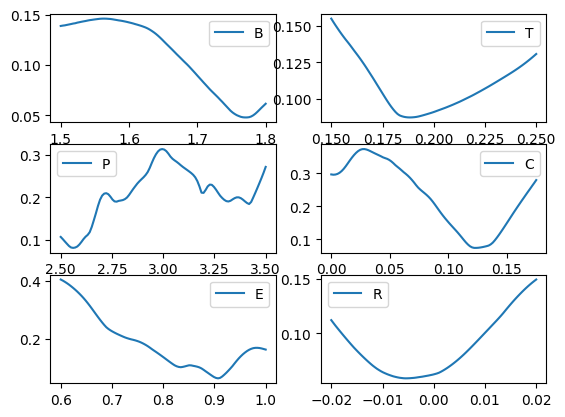

In [11]:
from matplotlib import pyplot as plt

paramdict = {
    "B": B.flatten(),
    "T": T.flatten(),
    "P": P.flatten(),
    "C": C.flatten(),
    "E": E.flatten(),
    "R": R.flatten()
}

fig, axes = plt.subplots(3, 2, squeeze=True)
axes = axes.flatten()

for ax, (idx, (param_name, param_values)) in zip(axes, enumerate(paramdict.items())):
    
    errors = check_variable(idx, param_values, dataset)
    
    order = jnp.argsort(param_values)
    
    ax.plot(param_values[order], errors[order], label=param_name)
    ax.legend()
    
print(f"Lift error: {errors.mean()} ± {errors.std()}")